This notebook tests the equivalence of original and proposed HMM posterior inference. See Issue #3.

In [5]:
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial

import matplotlib.pyplot as plt

from dynamax.hidden_markov_model.inference import hmm_posterior_sample

# utils

In [3]:
def random_hmm_args(key, num_timesteps, num_states, scale=1.0, n_mask=0):
    """Generate random HMM arguments, log-likelihoods, and masking.

    Arguments
        num_timesteps (int): number of timesteps in sequence, T
        num_states (int): number of hmm states, K
        scale (float): covariance scale
        n_mask (int): number of timesteps to mask

    Returns
        initial_probs: shape [K]
        transition_matrix: shape [K,K]
        log_likelihoods: shape [T,K]
        mask: shape [T]
    """
    k1, k2, k3, k4 = jr.split(key, 4)
    initial_probs = jr.uniform(k1, (num_states,))
    initial_probs /= initial_probs.sum()
    transition_matrix = jr.uniform(k2, (num_states, num_states))
    transition_matrix /= transition_matrix.sum(1, keepdims=True)

    log_likelihoods = scale * jr.normal(k3, (num_timesteps, num_states))

    mask = jnp.ones(num_timesteps, dtype=int)
    if n_mask > 0:
        i_flip = jr.randint(k4, (n_mask,), 0, num_timesteps)
        mask = mask.at[i_flip].set(0)

    return initial_probs, transition_matrix, log_likelihoods, mask

In [4]:
def expected_state_probability(sampled_states, num_states):
    """Compute expected state probability at each timestep given samples.

    Arguments
        sample_states (array): shape [N,T], taking on values 0,...,K-1
        num_states (int): Total number of states, K
    
    Returns
        expected_state_probabilities: shape [T,K]
    """

    count_state = lambda k: (sampled_states==k).sum(axis=0)
    counts = vmap(count_state, out_axes=-1)(jnp.arange(num_states))
    return counts/len(sampled_states)

In [74]:
def plot_probs_and_err(expected_original, expected_proposed, mask):
    num_timesteps, num_states = expected_original.shape

    err = abs(expected_original - expected_proposed)

    fig, axs = plt.subplots(nrows=num_states, ncols=2,
                            sharex=True, sharey='col',
                            gridspec_kw={'hspace': 0.01},
                            figsize=(10,5))

    # Don't plot timestep 1 since original moseq implementation hardcodes
    # initial_distribution to be uniform
    t_steps = jnp.arange(1, num_timesteps)
    for k, (ax_plt, ax_err) in enumerate(axs):
        l1, = ax_plt.plot(t_steps, expected_original[1:,k], label='original')
        l2, = ax_plt.plot(t_steps, expected_proposed[1:,k], label='proposed')
        ax_plt.set_ylabel(f'state {k}')

        ax_err.plot(t_steps, err[1:,k], color='k')

        # Plot masks
        m1 = None
        for i_mask in jnp.nonzero(1-mask)[0]:
            m1 = ax_plt.axvspan(i_mask, i_mask+1, alpha=0.4, facecolor='black', label='mask')
            ax_err.axvspan(i_mask, i_mask+1, alpha=0.4, facecolor='black')

    # Set column titles
    axs[0,0].set_title('state probability', y=1.25, fontsize=12)
    axs[0,1].set_title('difference', y=1.25, fontsize=12)

    # Label x-axis
    for ax in axs[-1]:
        ax.set_xlabel('timestep')

    # Add legend re: implementation
    handles, labels = [l1,l2,m1], ['original', 'proposed', 'mask']
    if m1 == None:
        handles, labels = handles[:-1], labels[:-1]
    axs[0,0].legend(handles=handles, labels=labels,
                    bbox_to_anchor=[0.5, 1], loc='lower center',
                    ncol=len(labels))

    # Remove spines
    for ax in axs.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    return fig, axs

# HMM posterior inference function implementations

## Original moseq implementation

Formerly in `jax_moseq.utils.distributions` module

In [6]:
def sample_discrete(seed, distn,dtype=jnp.int32):
    return jr.categorical(seed, jnp.log(distn))
    
def sample_hmm_stateseq(seed, log_likelihoods, mask, pi):
    """
    Use the forward-backward algorithm to sample state-sequences in a Markov chain.
    
    """
    def _forward_message(carry, args):
        ll_t, mask_t = args
        in_potential, logtot = carry
        cmax = ll_t.max()
        alphan_t = in_potential * jnp.exp(ll_t - cmax)
        norm = alphan_t.sum() + 1e-16
        alphan_t = alphan_t / norm
        logprob = jnp.log(norm) + cmax
        in_potential = alphan_t.dot(pi)*mask_t + in_potential*(1-mask_t)
        return (in_potential, logtot + logprob*mask_t), alphan_t    

    def _sample(args):
        seed, next_potential, alphan_t = args
        seed, newseed = jr.split(seed)
        s = sample_discrete(newseed, next_potential * alphan_t)
        next_potential = pi[:,s]
        return (seed,next_potential), s

    def _backward_message(carry, args):
        seed, next_potential = carry
        alphan_t, mask_t = args
        return jax.lax.cond(
            mask_t>0, _sample, 
            lambda args: (args[:-1],0), 
            (seed, next_potential, alphan_t))
        
    init_distn = jnp.ones(pi.shape[0])/pi.shape[0]
    (_,log_likelihood), alphan = jax.lax.scan(_forward_message,  (init_distn,0.), (log_likelihoods, mask))
    
    init_potential = jnp.ones(pi.shape[0])
    _,stateseq = jax.lax.scan(_backward_message, (seed,init_potential), (alphan,mask), reverse=True)
    return stateseq, log_likelihood

In [7]:
def original_sample_and_get_expected(seed, num_samples, num_states,
                                     initial_distribution, transition_matrix,
                                     log_likelihoods, mask):

    _sample = jax.vmap(partial(sample_hmm_stateseq,
                               log_likelihoods=log_likelihoods,
                               mask=mask,
                               pi=transition_matrix,))
    sampled_states, _ = _sample(jr.split(seed, num_samples))

    return expected_state_probability(sampled_states, num_states)

## Proposed moseq implementation

In [13]:
def sample_hmm_stateseq_proposed(seed, initial_distribution, transition_matrix, log_likelihoods, mask):
    masked_log_likelihoods = log_likelihoods * mask[:,None]
    return hmm_posterior_sample(seed, initial_distribution, transition_matrix, masked_log_likelihoods)


In [17]:
def proposed_sample_and_get_expected(seed, num_samples, num_states,
                                     initial_distribution, transition_matrix,
                                     log_likelihoods, mask):

    _sample = jax.vmap(partial(sample_hmm_stateseq_proposed,
                               initial_distribution=initial_distribution,
                               transition_matrix=transition_matrix,
                               log_likelihoods=log_likelihoods,
                               mask=mask,))
    _, sampled_states = _sample(jr.split(seed, num_samples))

    return expected_state_probability(sampled_states, num_states)

# Evaluate

## No masked observations

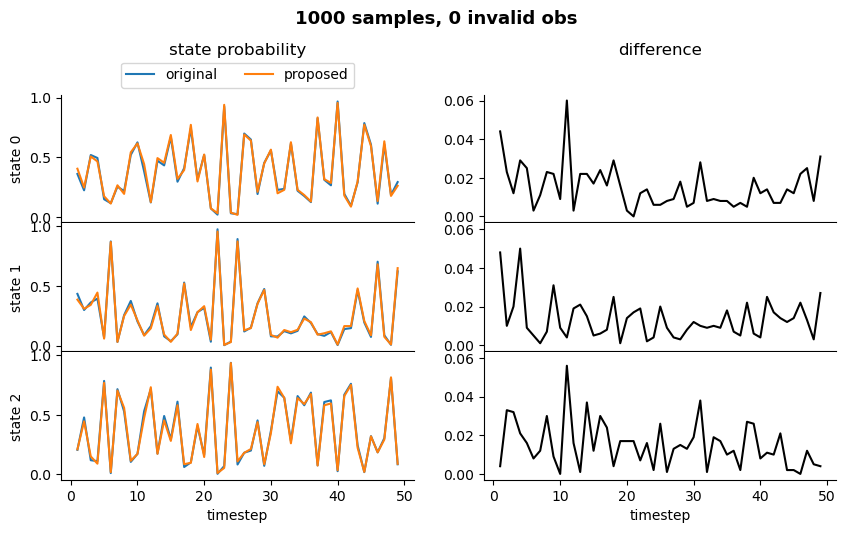

In [79]:
num_timesteps = 50
num_states = 3
num_samples = 1000
num_invalid = 0
seed = jr.PRNGKey(40192)

# ---------------------------------------
seed_params, seed_sample = jr.split(seed, 2)

initial_probs, transition_matrix, log_likelihoods, mask \
        = random_hmm_args(seed_params, num_timesteps, num_states, n_mask=num_invalid)

# Sample from implementations
seed_1, seed_2 = jr.split(seed_sample, 2)
expected_original = original_sample_and_get_expected(
    seed_1, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

expected_proposed = proposed_sample_and_get_expected(
    seed_2, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

# ---------------------------------------

fig, axs = plot_probs_and_err(expected_original, expected_proposed, mask)
fig.suptitle(f'{num_samples} samples, {num_invalid} invalid obs',
             fontsize=13, weight='bold', y=1.05)

# ---------------------------------------
assert jnp.allclose(expected_original[1:], expected_proposed[1:], atol=1e-1)

## Evaluate with 25% masked observations

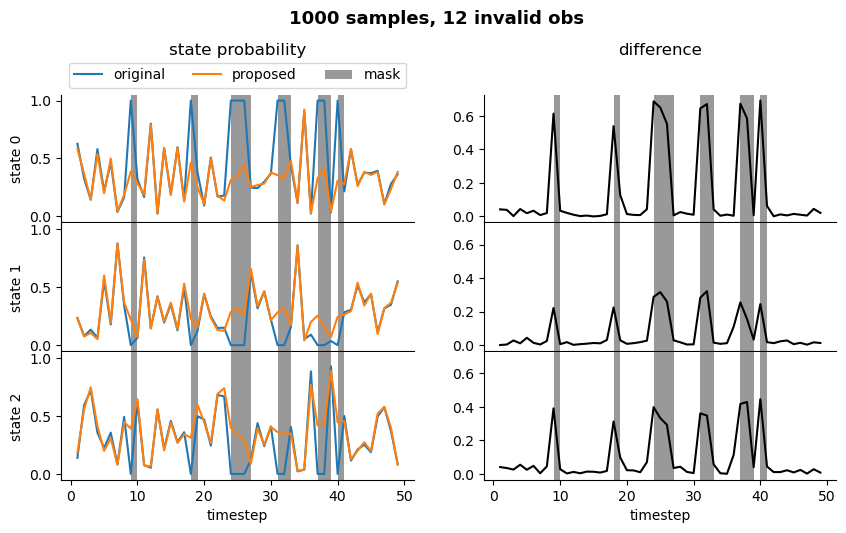

In [80]:
num_timesteps = 50
num_states = 3
num_samples = 1000
num_invalid = int(0.25*num_timesteps)
seed = jr.PRNGKey(4203)

# ---------------------------------------
seed_params, seed_sample = jr.split(seed, 2)

initial_probs, transition_matrix, log_likelihoods, mask \
        = random_hmm_args(seed_params, num_timesteps, num_states, n_mask=num_invalid)

# Sample from implementations
seed_1, seed_2 = jr.split(seed_sample, 2)
expected_original = original_sample_and_get_expected(
    seed_1, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

expected_proposed = proposed_sample_and_get_expected(
    seed_2, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

# ---------------------------------------
fig, axs = plot_probs_and_err(expected_original, expected_proposed, mask)
fig.suptitle(f'{num_samples} samples, {num_invalid} invalid obs',
                fontsize=13, weight='bold', y=1.05)

# ---------------------------------------
diff = abs(expected_original - expected_proposed)
assert (diff < 1e-1)[1:].sum() > 0.95

# Evaluate with invalid observations at end

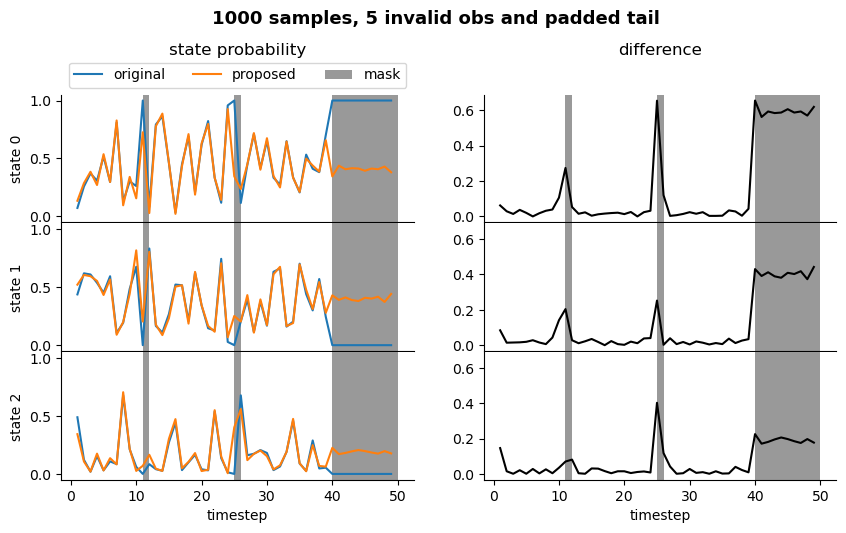

In [81]:
## Evaluate with 25% masked observations
num_timesteps = 50
num_states = 3
num_samples = 1000
num_invalid = int(0.10*num_timesteps)
seed = jr.PRNGKey(983)

# ---------------------------------------
seed_params, seed_sample = jr.split(seed, 2)

initial_probs, transition_matrix, log_likelihoods, mask \
        = random_hmm_args(seed_params, num_timesteps, num_states, n_mask=num_invalid)

mask = mask.at[-10:].set(0)

# Sample from implementations
seed_1, seed_2 = jr.split(seed_sample, 2)
expected_original = original_sample_and_get_expected(
    seed_1, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

expected_proposed = proposed_sample_and_get_expected(
    seed_2, num_samples, num_states, initial_probs, transition_matrix, log_likelihoods, mask)

# ---------------------------------------
fig, axs = plot_probs_and_err(expected_original, expected_proposed, mask)
fig.suptitle(f'{num_samples} samples, {num_invalid} invalid obs and padded tail',
                fontsize=13, weight='bold', y=1.05)

# ---------------------------------------
diff = abs(expected_original - expected_proposed)
assert (diff < 1e-1)[1:].sum() > 0.95